## Análise de Resultados

In [1]:
import sys, os
import plotly.graph_objects as go
import numpy as np

sys.path.insert(0, "/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz")
import pandas as pd
import argparse
import copy
import numpy as np
import os
import random
import json
from pandas.io.json import json_normalize
from app import fetch_iteraction_results_path, load_all_iteraction_metrics
from app import load_iteractions_params as load_iteractions_params2, PATH_EVAL_REINFORCEMENT
from plot import plot_line_iteraction, plot_exploration_arm, get_colors, confidence
import pandas as pd
import argparse
import copy
import numpy as np
import streamlit as st
import seaborn as sns
sns.set(style="darkgrid")
#sys.path.insert(0, os.path.dirname(__file__))
import matplotlib.pyplot as plt
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path


In [2]:
# models_and_legend = {
#   "____random_":           ["bandit_policy", "observation"],
#   "____fixed_":            ["bandit_policy", "observation"],
#   "____lin_ucb_":          ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
#   "____model_":            ["bandit_policy","full_refit", "val_split_type"],
#   "____custom_lin_ucb_":   ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
#   "____epsilon_greedy_":   ["bandit_policy","bandit_policy_params.epsilon", "full_refit", "val_split_type"],
#   "____softmax_":          ["bandit_policy","bandit_policy_params.logit_multiplier", "full_refit", "val_split_type"],
#   "____lin_ts_":           ["bandit_policy","bandit_policy_params.v_sq", "full_refit", "val_split_type"],
#   "____percentile_adapt_":       ["bandit_policy","bandit_policy_params.exploration_threshold", "full_refit", "val_split_type"],
#   "____adaptive_":         ["bandit_policy","bandit_policy_params.exploration_threshold", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],  
#   "____explore_then_exp_": ["bandit_policy","bandit_policy_params.explore_rounds", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],    
# }

models_and_legend = {
  "____remote_":           ["bandit_policy", "obs"],
}
path = PATH_EVAL_REINFORCEMENT

In [3]:
models_and_legend

{'____remote_': ['bandit_policy', 'obs']}

In [4]:
def list_paths_per_model(input_path):
    models = []
    
    for model, legend in models_and_legend.items():
    #print(model)
    #print(legend)
        for root, dirs, files in os.walk(input_path):
            if '/results' in root and 'Interaction' in root:
                for d in dirs:
                    #print(os.path.join(root, d))
                    if model in d:
                        models.append(os.path.join(root, d))
    return models

def load_iteractions_params(iteractions):
  if len(iteractions) == 0:
    return pd.DataFrame()

  dfs = []

  for model in iteractions:

    file_path = os.path.join(model, 'params.json')
    data      = []

    #try:
    with open(file_path) as json_file:
        d = json.load(json_file)
        data.append(d)

        df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')
      
    #except:
    #  df = pd.DataFrame()

    df['iteraction'] = model
    dfs.append(df)
  
  return pd.concat(dfs)


def load_data_iteractions_metrics(path, sample_size = 10000):
    random.seed(42)
    file      = os.path.join(path,'sim-datalog.csv')

    # Count the lines
    num_lines = sum(1 for l in open(file)) - 1

    # Sample size - in this case ~10%
    size = np.min([sample_size, num_lines])#int(num_lines / 10)

    # The row indices to skip - make sure 0 is not included to keep the header!
    skip_idx  = sorted(random.sample(range(1, num_lines), num_lines - size))
    idx       = list(set(list(range(num_lines))) - set(skip_idx))

    df        = pd.read_csv(file, skiprows=skip_idx)
    
    df        = pd.read_csv(file)#.reset_index()
    idx       = list(range(len(df)))

    df['idx'] = sorted(idx)
    df        = df.sort_values("idx")
    return df


def get_metrics_reward(bandits):
    data    = []
    for i, p in enumerate(bandits):
        df_metrics = load_data_iteractions_metrics(p)
        r_mean     = df_metrics.reward.mean()
        r_reward   = df_metrics.reward.sum()
        data.append((i, r_mean, r_reward))
    df_metrics = pd.DataFrame(data, columns=['idx', 'r_mean', 'r_reward']).set_index('idx')    
    return df_metrics

def group_metrics(df):
    df_g_metrics = df.groupby('bandit').agg({'r_mean': ['mean', 'std'], 'r_reward': ['mean', 'std', 'count'], 'model': 'first' })
    df_g_metrics.columns = df_g_metrics.columns.map(lambda x: '|'.join([str(i) for i in x]))
    return df_g_metrics    
    
result_paths = list_paths_per_model(path)
result_paths

['output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______ae87ca9ccb',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______d7ec2bac42',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______af7c690687',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a0eec06ce4',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______e681969ab3',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______3d7e28c225',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______cf553d4e51',
 'output/interaction/Ensambl

In [15]:
fetch_results_path()

{'TrivagoLogisticModelInteraction_selu____softmax_explorer_ecf6ca42ee_89372c6587_ps_per_logistic_regression_of_pos_item_idx_and_item_ps': 'output/evaluation/EvaluateTrivagoTestSetPredictions/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_ecf6ca42ee_89372c6587_ps_per_logistic_regression_of_pos_item_idx_and_item_ps',
 'TrivagoLogisticModelInteraction_selu____softmax_explorer_ecf6ca42ee_c77d82b7ff_ps_per_logistic_regression_of_pos_item_idx_and_item': 'output/evaluation/EvaluateTrivagoTestSetPredictions/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_ecf6ca42ee_c77d82b7ff_ps_per_logistic_regression_of_pos_item_idx_and_item'}

## Filter Data

In [16]:
result_paths

['output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______ae87ca9ccb',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______d7ec2bac42',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______af7c690687',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a0eec06ce4',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______e681969ab3',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______3d7e28c225',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______cf553d4e51',
 'output/interaction/Ensambl

In [7]:
df_params = load_iteractions_params(result_paths)
df_params.head()

/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,balance_fields,bandit_policy,bandit_policy_params.endpoints,bandit_policy_params.window_reward,batch_size,dataset_split_method,device,early_stopping_min_delta,early_stopping_patience,epochs,...,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,user_column,user_idx_column,val_size,val_split_type
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,500,time,cuda,0.001,5,100,...,5,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,500,time,cuda,0.001,5,100,...,6,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_epsilon_greedy,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",500.0,500,time,cuda,0.001,5,100,...,2,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_softmax,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,500,time,cuda,0.001,5,100,...,6,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,500,time,cuda,0.001,5,100,...,2,0.1,0,0.0,time,False,account_id,account_idx,0.0,time


In [18]:
df_params.obs.unique()

array(['[MAB] UCB  5', '[MAB] UCB  6', '[MAB] e-greedy 2',
       '[Contextual] Softmax 6', '[MAB] UCB  2', '[MAB] e-greedy 5',
       'MostPopularPerUser', '[Contextual] Softmax 3',
       '[Contextual] e-greedy 1', '[MAB] e-greedy 10',
       '[Contextual] e-greedy 8', 'CDAE', '[MAB] e-greedy 9',
       '[MAB] UCB  3', 'MostPopular', '[MAB] e-greedy 3',
       'MatrixFactorization', '[Contextual] e-greedy 4',
       '[MAB] e-greedy 1', '[Contextual] Softmax 2', '[MAB] e-greedy 4',
       '[Contextual] Softmax 1', '[Contextual] e-greedy 9',
       '[Contextual] e-greedy 7', '[MAB] UCB  7', '[MAB] UCB  4',
       '[Contextual] Softmax 9', '[Contextual] Softmax 8', '[MAB] UCB  9',
       '[MAB] UCB  1', '[Contextual] Softmax 10',
       '[Contextual] e-greedy 3', '[Contextual] Softmax 5',
       '[Contextual] Softmax 4', '[MAB] UCB  10', '[MAB] e-greedy 8',
       '[MAB] UCB  8', '[MAB] e-greedy 7', 'CVAE',
       '[Contextual] Softmax 7', '[Contextual] e-greedy 5',
       '[Contextual]

In [20]:
df_params['obs'].apply(lambda x: " ".join(x.split(" ")[:-1]).strip()).unique()

array(['[MAB] UCB', '[MAB] e-greedy', '[Contextual] Softmax', '',
       '[Contextual] e-greedy'], dtype=object)

In [27]:
#city = "Rio de Janeiro, Brazil"
#city = "Como, Italy"
#city = "Chicago, USA"
#city = "New York, USA"
#city = 'Copenhagen, Denmark'
# city='recsys'

# df_params = df_params[df_params['data_frames_preparation_extra_params.filter_city'] == city]
# df_params.head()

In [24]:
"CVAE".split(" ")

['CVAE']

In [28]:
df_params
#df_params['observation'] = df_params['obs'].apply(lambda x: " ".join(x.split(" ")[:-2]))
df_params['observation'] = df_params['obs'].apply(lambda x: " ".join(x.split(" ")[:-1]) if len(x.split(" ")) > 1 else x)
df_params['observation'].unique()

array(['[MAB] UCB ', '[MAB] e-greedy', '[Contextual] Softmax',
       'MostPopularPerUser', '[Contextual] e-greedy', 'CDAE',
       'MostPopular', 'MatrixFactorization', 'CVAE', 'Random'],
      dtype=object)

In [29]:
list_bandits          = df_params.groupby(["bandit_policy", "observation"])['iteraction'].apply(list).reset_index()
list_bandits['name']  = list_bandits.bandit_policy.map(str) + ' ' + list_bandits.observation.map(str)
list_bandits['name']  = list_bandits['name'].apply(lambda x: x.replace("fixed ", "").replace(" ", ""))
list_bandits['model'] = list_bandits.iteraction.apply(lambda l: l[np.random.randint(0, len(l))])
list_bandits['model_list'] = list_bandits.iteraction
list_bandits

,bandit_policy,observation,iteraction,name,model,model_list
0,remote,CDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6],remoteCDAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
1,remote,CVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920],remoteCVAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]
2,remote,MatrixFactorization,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b],remoteMatrixFactorization,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b]
3,remote,MostPopular,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a],remoteMostPopular,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a]
4,remote,MostPopularPerUser,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43],remoteMostPopularPerUser,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43]
5,remote,Random,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7],remoteRandom,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7]
6,remote_contextual_epsilon_greedy,[Contextual] e-greedy,"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c87eb8d2e4, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c8e04246ca, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4e6c98d63b, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______fcb92f2a09, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______08b565350d, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______28dd73806b, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______659dab8004, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______e7f48c2e17, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______7d9bc9b8c0, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______09a2bee226]",remote_contextual_epsilon_greedy[Contextual]e-greedy,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______28dd73806b,"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c87eb8d2e4, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c8e0

In [30]:
df_params

,balance_fields,bandit_policy,bandit_policy_params.endpoints,bandit_policy_params.window_reward,batch_size,dataset_split_method,device,early_stopping_min_delta,early_stopping_patience,epochs,...,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,user_column,user_idx_column,val_size,val_split_type
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,500,time,cuda,0.001,5,100,...,5,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,500,time,cuda,0.001,5,100,...,6,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_epsilon_greedy,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",500.0,500,time,cuda,0.001,5,100,...,2,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_softmax,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,500,time,cuda,0.001,5,100,...,6,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_ucb,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,500,time,cuda,0.001,5,100,...,2,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_epsilon_greedy,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",500.0,500,time,cuda,0.001,5,100,...,5,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote,[http://localhost:5002/rank],NaN,500,time,cuda,0.001,5,100,...,42,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_softmax,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,500,time,cuda,0.001,5,100,...,3,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,500,time,cuda,0.001,5,100,...,1,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_epsilon_greedy,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",500.0,500,time,cuda,0.001,5,100,...,10,0.1,0,0.0,time,False,account_id,account_idx,0.0,time


## Geral

In [31]:
reward_metrics = []
list_bandits.head(2)

,bandit_policy,observation,iteraction,name,model,model_list
0,remote,CDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6],remoteCDAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
1,remote,CVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920],remoteCVAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]


In [32]:
for i, row in list_bandits.iterrows():
    try:
        df_metrics = get_metrics_reward(row['iteraction'])
        
        df_metrics['bandit'] = str(row['bandit_policy']) + " " + str(row['observation'])
        df_metrics['model']  = row['model']

        df_g_metrics = group_metrics(df_metrics)
        reward_metrics.append(df_g_metrics)
    except FileNotFoundError:
        pass

In [33]:
df_all = pd.concat(reward_metrics)
df_all = df_all.reset_index().sort_values('bandit', ascending=False).set_index('bandit')
df_all

,r_mean|mean,r_mean|std,r_reward|mean,r_reward|std,r_reward|count,model|first
bandit,,,,,,
remote_ucb [MAB] UCB,0.107383,0.000000,1232.0,0.000000,10,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______ae87ca9ccb
remote_epsilon_greedy [MAB] e-greedy,0.109474,0.000000,1256.0,0.000000,10,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______7f209d7401
remote_contextual_softmax [Contextual] Softmax,0.111836,0.000251,1283.1,2.884826,10,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______ec8896ee5f
remote_contextual_epsilon_greedy [Contextual] e-greedy,0.160028,0.001899,1836.0,21.781746,10,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______28dd73806b
remote Random,0.030158,NaN,346.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7
remote MostPopularPerUser,0.157326,NaN,1805.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43
remote MostPopular,0.091432,NaN,1049.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a
remote MatrixFactorization,0.105552,NaN,1211.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b
remote CVAE,0.110869,NaN,1272.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920


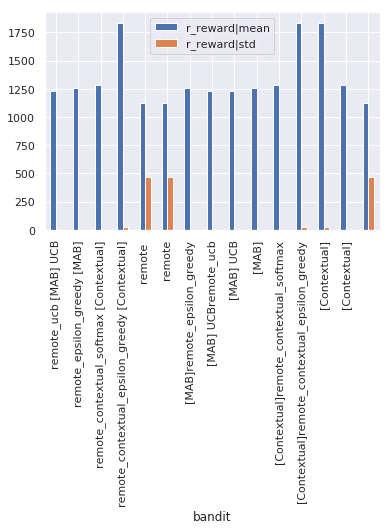

In [59]:
df_all[['r_reward|mean', 'r_reward|std']].plot(kind='bar')

In [34]:
df_all.to_csv("output/tmp/stats.csv")

## Plot Test

In [152]:
list_bandits['name'] = list_bandits['name'].apply(lambda x: "popular_item" if x == "PopularItem" else x)
df_models = list_bandits.set_index('name')[['model_list']]


legend = {'remoteCDAE': "CDAE", 
 'remoteCVAE': "CVAE",  
 'remoteMatrixFactorization': 'Matrix Factorization',
 'remoteMostPopular': 'Most Popular',
 'remoteMostPopularPerUser': 'Most Popular per User',
 'remoteRandom': 'Random',
 'remote_contextual_epsilon_greedy[Contextual]e-greedy': 'Contextual e-greedy',
 'remote_contextual_softmax[Contextual]Softmax': 'Contextual Softmax',
 'remote_epsilon_greedy[MAB]e-greedy': 'e-greedy', 
 'remote_ucb[MAB]UCB': 'UCB'
}

In [153]:
df_models.index = df_models.index.map(legend)
#df_models['model'] = df_models['bandit']
df_models.head()

,model_list
name,
CDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
CVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]
Matrix Factorization,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b]
Most Popular,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a]
Most Popular per User,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43]


In [154]:
bandits           = legend.values()

sample_size       = 15000
window_size       = 1000 

In [242]:
df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)

df_metrics.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).rolling(window = window_size, min_periods=1).mean().reset_index(drop=True)

,user,item,reward,index_env
0,174845.000,1455.000,0.000,0.0
1,129435.000,3872.000,0.000,0.5
2,238922.000,3377.000,0.000,1.0
3,273635.000,3242.750,0.000,1.5
4,246937.600,3209.200,0.000,2.0
...,...,...,...,...
11468,238132.107,3762.227,0.096,10968.5
11469,238161.039,3759.892,0.095,10969.5
11470,238204.960,3757.557,0.094,10970.5
11471,238113.754,3753.906,0.093,10971.5


In [257]:
def load_dataset(df_models, bandits, sample_size):
    data = []
    for bandit in bandits:
        input_iteraction  = [p.split("/")[-1] for p in df_models.loc[bandit].model_list]
        df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)
        #params            = load_iteractions_params2(input_iteraction)
        
        
        df        = load_all_iteraction_metrics(input_iteraction, sample_size)
        df['_idx'] = 1
        df_metrics                    = df.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).cumsum().reset_index()
        df_metrics['mean_reward']     = (df_metrics.reward/df_metrics._idx).fillna(0)
        df_metrics['mean_reward_win'] = df.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).rolling(window = window_size, min_periods=1).mean().reset_index(drop=True).reward

        df_metrics['bandit']      = bandit
        df_metrics['Model']       = bandit

        data.append(df_metrics)
    return pd.concat(data, ignore_index=True)

def plot_cum_reward(df, column='mean_reward', hue='bandit', legend=False, ylim=1):
    #df = df[df.idx > 10]
    df = df.sample(200, random_state=41)
    
    plt.figure()
    sns.set(style="darkgrid")

    # Plot the responses for different events and regions
    ax =  sns.lineplot(x="idx", y=column, markers=True, dashes=False, style=hue, hue=hue, legend=legend, data=df)
    ax.set_ylim(0,ylim)
    #ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward',fontsize=20)
    ax.tick_params(labelsize=11)
    ax.set_xlabel('Interactions',fontsize=15);
    ax.set_ylabel('Cumulative Reward',fontsize=15);
    # Put the legend out of the figure
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
    plt.savefig("output/tmp/plot_cum_reward.pdf",dpi=300, bbox_inches="tight")
    plt.show()
    
df_group = load_dataset(df_models, bandits, sample_size)
df_group.tail()

,iteraction,idx,user,item,reward,index_env,_idx,mean_reward,mean_reward_win,bandit,Model
527753,EnsambleMABInteraction____remote_ucb___endpoints______e681969ab3,11468,2730766679,45014627,1231.0,65763246,11469,0.107333,0.101,UCB,UCB
527754,EnsambleMABInteraction____remote_ucb___endpoints______e681969ab3,11469,2731015101,45019554,1231.0,65774715,11470,0.107323,0.101,UCB,UCB
527755,EnsambleMABInteraction____remote_ucb___endpoints______e681969ab3,11470,2731278512,45024481,1231.0,65786185,11471,0.107314,0.101,UCB,UCB
527756,EnsambleMABInteraction____remote_ucb___endpoints______e681969ab3,11471,2731406796,45030939,1231.0,65797656,11472,0.107305,0.101,UCB,UCB
527757,EnsambleMABInteraction____remote_ucb___endpoints______e681969ab3,11472,2731788585,45035421,1232.0,65809128,11473,0.107383,0.102,UCB,UCB


In [258]:
#df_group['idx'].isin(df_group.idx.sample(200, random_state=41))

### Cumulative Reward

In [259]:
legend.values()

dict_values(['CDAE', 'CVAE', 'Matrix Factorization', 'Most Popular', 'Most Popular per User', 'Random', 'Contextual e-greedy', 'Contextual Softmax', 'e-greedy', 'UCB'])

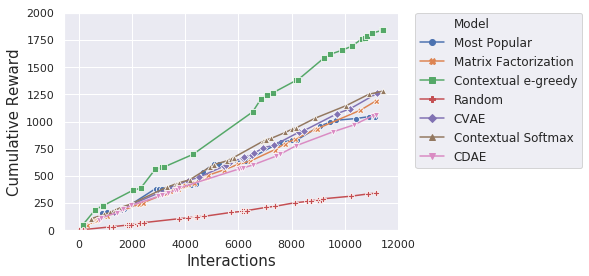

In [260]:
# bandits           = ['remoteCDAE', 'remoteCVAE', 'remoteMatrixFactorization',
#                    'remoteMostPopular', 'remoteMostPopularPerUser', 'remoteRandom',
#                    'remote_contextual_epsilon_greedy[Contextual]e-greedy',
#                    'remote_contextual_softmax[Contextual]Softmax',
#                    'remote_epsilon_greedy[MAB]e-greedy', 'remote_ucb[MAB]UCB']

df_group = load_dataset(df_models, ['Random', 'Most Popular', 'CDAE', 'CVAE', 
                                    'Matrix Factorization', 'Contextual e-greedy', 'Contextual Softmax'], sample_size)

df_group = df_group.groupby(['Model', 'idx']).median().reset_index()

plot_cum_reward(df_group, column='reward', legend='full', hue='Model', ylim=2000)

### Cumulative Mean Reward

In [284]:
def plot_cum_mean_reward(df, column='mean_reward', hue='bandit', legend=False, ylim=1):
    df = df.sample(200, random_state=41)
    plt.figure()
    sns.set(style="darkgrid")

    # Plot the responses for different events and regions
    ax =  sns.lineplot(x="idx", y=column, markers=True, dashes=False, style=hue, hue=hue, legend=legend, data=df)
    ax.set_ylim(0,ylim)
    #ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward',fontsize=20)
    ax.tick_params(labelsize=11)
    ax.set_xlabel('Interactions',fontsize=15);
    ax.set_ylabel('Cumulative Mean Reward',fontsize=15);
    # Put the legend out of the figure
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
    plt.savefig("output/tmp/plot_cum_mean_reward.pdf",dpi=300, bbox_inches="tight")
    plt.show()


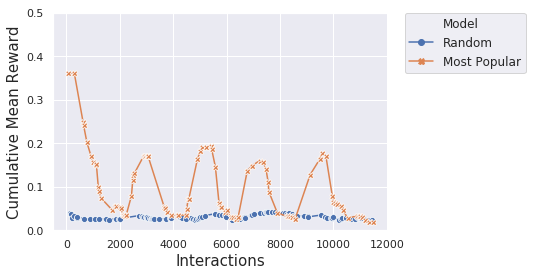

In [285]:
# bandits           = ['remoteCDAE', 'remoteCVAE', 'remoteMatrixFactorization',
#                    'remoteMostPopular', 'remoteMostPopularPerUser', 'remoteRandom',
#                    'remote_contextual_epsilon_greedy[Contextual]e-greedy',
#                    'remote_contextual_softmax[Contextual]Softmax',
#                    'remote_epsilon_greedy[MAB]e-greedy', 'remote_ucb[MAB]UCB']

df_group = load_dataset(df_models, ['Random', 'Most Popular'], sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', legend='full', hue='Model', ylim=0.5)

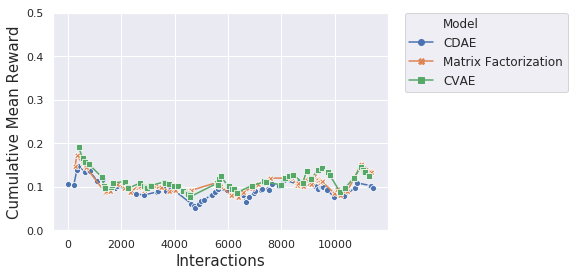

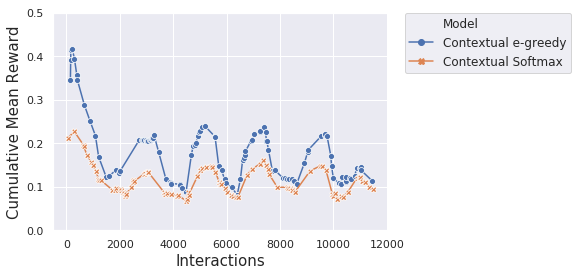

In [288]:

df_group = load_dataset(df_models, ['Contextual e-greedy', 'Contextual Softmax'], sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', legend='full', hue='Model', ylim=0.5)

In [203]:
# input_iteraction  = [p.split("/")[-1] for p in df_models.loc['remoteCDAE'].model_list]

# df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)
# df_metrics['_idx'] = 1
# df_metrics        = df_metrics.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).cumsum().reset_index()
# df_metrics['mean_reward'] = (df_metrics.reward/df_metrics.idx).fillna(0)
# df_metrics['cum_reward']  = df_metrics.reward.cumsum()
# df_metrics

In [57]:
df_group.head()

,iteraction,idx,user,item,reward,index_env,_idx,mean_reward,bandit
0,EnsambleMABInteraction____remote_contextua___endpoints______08b565350d,0,377774,2387,0.0,3,1,0.0,remote_contextual_epsilon_greedy[Contextual]e-greedy
1,EnsambleMABInteraction____remote_contextua___endpoints______08b565350d,4,520963,8845,0.0,37,2,0.0,remote_contextual_epsilon_greedy[Contextual]e-greedy
2,EnsambleMABInteraction____remote_contextua___endpoints______08b565350d,35,932501,15217,0.0,73,3,0.0,remote_contextual_epsilon_greedy[Contextual]e-greedy
3,EnsambleMABInteraction____remote_contextua___endpoints______08b565350d,37,958947,21589,0.0,110,4,0.0,remote_contextual_epsilon_greedy[Contextual]e-greedy
4,EnsambleMABInteraction____remote_contextua___endpoints______08b565350d,38,1134089,27961,0.0,155,5,0.0,remote_contextual_epsilon_greedy[Contextual]e-greedy


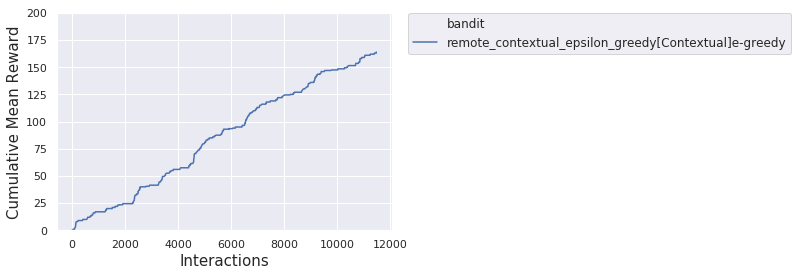

In [70]:
_df = df_group.groupby(['bandit', 'idx']).median().reset_index()
plot_cum_reward(_df, column='reward', legend='full', ylim=200)

In [54]:
#df_metrics
# df_group = load_dataset(df_models, bandits, 20000)
# plot_cum_reward(df_group, hue='bandit', legend='full')

In [55]:
#df_group

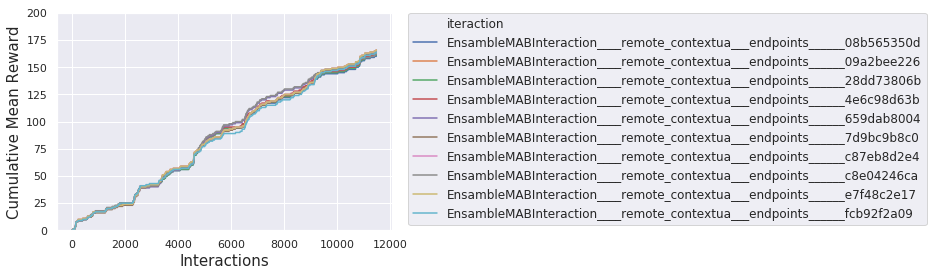

In [72]:
df_group = load_dataset(df_models, ['remote_contextual_epsilon_greedy[Contextual]e-greedy'], 1000)
df_group
plot_cum_reward(df_group,  hue='iteraction', legend='full', column='reward', ylim=200)

In [46]:
df_group.head()

,iteraction,idx,user,item,reward,index_env,_idx,mean_reward,bandit
0,EnsambleMABInteraction____remote___endpoints______68e9460cc6,0,174845,1455,0.0,0,1,0.0,remoteCDAE
1,EnsambleMABInteraction____remote___endpoints______68e9460cc6,1,258870,7744,0.0,1,2,0.0,remoteCDAE
2,EnsambleMABInteraction____remote___endpoints______68e9460cc6,2,716766,10131,0.0,3,3,0.0,remoteCDAE
3,EnsambleMABInteraction____remote___endpoints______68e9460cc6,3,1094540,12971,0.0,6,4,0.0,remoteCDAE
4,EnsambleMABInteraction____remote___endpoints______68e9460cc6,4,1234688,16046,0.0,10,5,0.0,remoteCDAE


In [47]:
# sns.set(style="darkgrid")

# # Plot the responses for different events and regions
# ax =  sns.lineplot(x="idx", y="mean_reward", hue='bandit', legend=False, data=df_group)
# ax.set_ylim(0,0.35)
# ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward')

# # Put the legend out of the figure
# #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig("output/tmp/iteraction.pdf",dpi=300)
# plt.show()

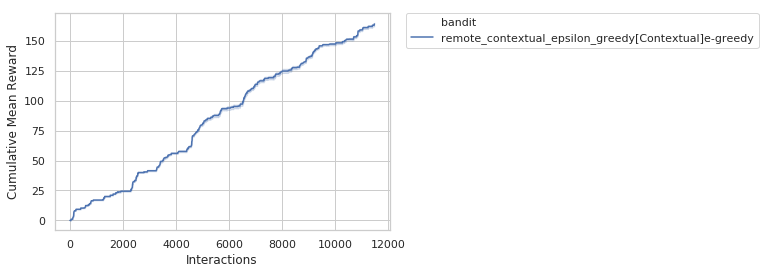

In [73]:
sns.set_style("whitegrid")

# Plot the responses for different events and regions
ax =  sns.lineplot(x="idx", y="reward", hue='bandit', legend='full', data=df_group)
ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("output/tmp/iteraction_2.png",dpi=300)

plt.show()

## Plot

In [32]:

removed           = df_all.loc[['model ', 'FirstItem']]['model|first'].values

input_legend      = ['bandit_policy', 'observation']
input_iteraction  = [p.split("/")[-1] for p in df_all['model|first'] if p not in removed]
sample_size       = 10000
window_size       = 1000 

st.set_option("client.displayEnabled", False)

metrics           = load_all_iteraction_metrics(input_iteraction, sample_size)
params            = load_iteractions_params2(input_iteraction)

df_metrics_reward = metrics.groupby("iteraction").agg({'reward': ['mean', 'sum']}).reset_index().sort_values([('reward', 'sum')], ascending=False)

df  = metrics.merge(params, on=['iteraction'], how='left')\
            .merge(metrics.groupby("iteraction")\
                    .agg({'reward': 'mean'})\
                    .rename(columns={'reward': 'sum_reward'})\
                    .reset_index(), 
              on=['iteraction'], how='left')\
            .reset_index()\
            .sort_values(['sum_reward', 'idx'], ascending=[False, True])


df.to_pickle('output/tmp/iteraction_df.pkl')
df.head()

NameError: name 'df_all' is not defined

In [33]:
df

NameError: name 'df' is not defined

In [34]:
df

NameError: name 'df' is not defined

In [35]:
df = df[df.bandit_policy != "model"]

NameError: name 'df' is not defined

In [36]:
k = 100
for i in range(k):
    
    for input_metrics in ['Cumulative Window Mean Reward', 'Cumulative Mean Reward']:

        #input_metrics = 'Cumulative Mean Reward'
        fig = plot_line_iteraction(df[df.idx < int((df.idx.max()/k) *i)], 'reward', 
                              title=input_metrics, 
                              legend=input_legend,
                              yrange=[0, 0.35], 
                              line_dict=get_colors(input_iteraction),
                              window=window_size,
                              cum=(input_metrics == 'Cumulative Reward'), 
                              mean=(input_metrics == 'Cumulative Mean Reward'),
                              roll=(input_metrics == 'Cumulative Window Mean Reward'))
        fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
        fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
        fig.update_yaxes(range=[0, 0.5])
        fig.update_xaxes(range=[0, df.idx.max()])
        #fig.show(renderer="svg")
        fig.write_image("output/tmp/interactions/{}_{}.png".format(input_metrics, i)) #, width=1024, height=600, scale=2
        print(i,"... ")

NameError: name 'df' is not defined

In [37]:
df = pd.read_pickle('output/tmp/iteraction_df.pkl')

# GERAL
for input_metrics in ['Cumulative Reward', 'Cumulative Window Mean Reward', 'Cumulative Mean Reward']:
    #input_metrics = 'Cumulative Mean Reward'
    fig = plot_line_iteraction(df, 'reward', 
                          title=input_metrics, 
                          legend=input_legend,
                          yrange=[0, 0.35], 
                          line_dict=get_colors(input_iteraction),
                          window=window_size,
                          cum=(input_metrics == 'Cumulative Reward'), 
                          mean=(input_metrics == 'Cumulative Mean Reward'),
                          roll=(input_metrics == 'Cumulative Window Mean Reward'))
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, title="{} - dataset".format(city))
    fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
    fig.show(renderer="svg")

    fig.write_image("output/tmp/iteraction_{}.eps".format(input_metrics.replace(" ", "_"))) #, width=1024, height=600, scale=2

NameError: name 'input_legend' is not defined

## Recsys Metrics

In [38]:
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path
from plot import plot_bar

RECSYS_METRICS = [
  "count",
  "mean_average_precision",
  "precision_at_1",
  "ndcg_at_5",
  "ndcg_at_10",
  "ndcg_at_15",
  "ndcg_at_20",
  "ndcg_at_50",
  "coverage_at_5",
  "coverage_at_10",
  "coverage_at_15",
  "coverage_at_20",
  "coverage_at_50",
  "personalization_at_5",
  "personalization_at_10",
  "personalization_at_15",
  "personalization_at_20",
  "personalization_at_50",
  "IPS",
  "CIPS",
  "SNIPS",
  "DirectEstimator",
  "DoublyRobust"]


input_metrics = [
  "precision_at_1",
  "ndcg_at_5",
  "coverage_at_5",
  "personalization_at_5",
  "IPS",
  "CIPS",
  "SNIPS",
  "DirectEstimator",
  "DoublyRobust"
]

In [39]:
input_models_eval = fetch_results_path().keys()
input_params      = []
input_models_eval

dict_keys([])

In [40]:
data_metrics       = load_data_metrics()
data_params        = load_eval_params()

df_metrics        = filter_df(data_metrics, input_models_eval, input_metrics, "")
df_eval_params    = filter_df(data_params, input_models_eval, input_params).transpose()

KeyError: "None of ['path'] are in the columns"

In [7]:
confidence_metrics = data_metrics[[c for c in data_metrics.columns if "_C" in c]]
for c in input_metrics:
    c_column = c+"_C" 
    confidence_metrics[c_column] = data_metrics[c_column] if c_column in data_metrics else None
confidence_metrics = confidence_metrics[[c+"_C" for c in input_metrics]]

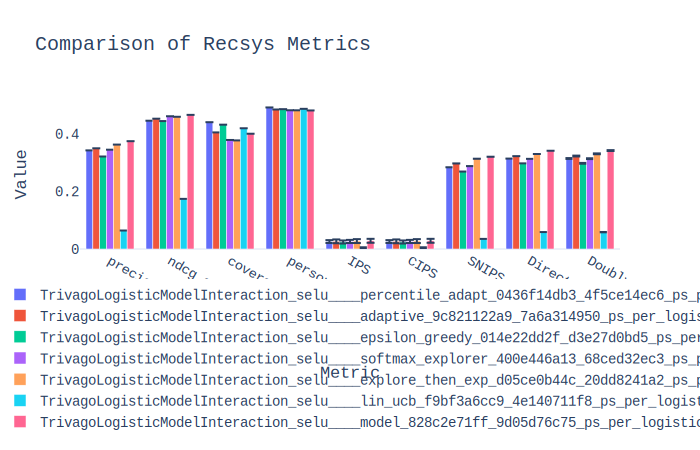

In [8]:
fig = plot_bar(df_metrics, confidence = confidence_metrics, title="Comparison of Recsys Metrics")

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
fig.show(renderer="svg")

#fig.write_image("output/tmp/metrics/recsys_rank.eps")

In [14]:
confidence_metrics

,precision_at_1_C,ndcg_at_5_C,coverage_at_5_C,personalization_at_5_C,IPS_C,CIPS_C,SNIPS_C,DirectEstimator_C,DoublyRobust_C
path,,,,,,,,,
TrivagoLogisticModelInteraction_selu____percentile_adapt_0436f14db3_4f5ce14ec6_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,None,None,None,None,0.004920,0.004920,0.000078,None,0.001470
TrivagoLogisticModelInteraction_selu____adaptive_9c821122a9_7a6a314950_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,None,None,None,None,0.006638,0.006638,0.000116,None,0.001483
TrivagoLogisticModelInteraction_selu____epsilon_greedy_014e22dd2f_d3e27d0bd5_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,None,None,None,None,0.005363,0.005363,0.000093,None,0.001446
TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,None,None,None,None,0.005436,0.005436,0.000090,None,0.001456
TrivagoLogisticModelInteraction_selu____explore_then_exp_d05ce0b44c_20dd8241a2_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,None,None,None,None,0.006761,0.006761,0.000119,None,0.001490
TrivagoLogisticModelInteraction_selu____lin_ucb_f9bf3a6cc9_4e140711f8_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,None,None,None,None,0.002417,0.002417,0.000043,None,0.000584
TrivagoLogisticModelInteraction_selu____model_828c2e71ff_9d05d76c75_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,None,None,None,None,0.006873,0.006873,0.000119,None,0.001491


In [15]:
df_metrics.round(3)

,precision_at_1,ndcg_at_5,coverage_at_5,personalization_at_5,IPS,CIPS,SNIPS,DirectEstimator,DoublyRobust
path,,,,,,,,,
TrivagoLogisticModelInteraction_selu____percentile_adapt_0436f14db3_4f5ce14ec6_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,0.343,0.446,0.441,0.492,0.026,0.026,0.284,0.314,0.315
TrivagoLogisticModelInteraction_selu____adaptive_9c821122a9_7a6a314950_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,0.350,0.453,0.405,0.485,0.027,0.027,0.297,0.323,0.323
TrivagoLogisticModelInteraction_selu____epsilon_greedy_014e22dd2f_d3e27d0bd5_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,0.321,0.445,0.432,0.486,0.024,0.024,0.269,0.298,0.298
TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,0.345,0.461,0.379,0.482,0.026,0.026,0.288,0.313,0.314
TrivagoLogisticModelInteraction_selu____explore_then_exp_d05ce0b44c_20dd8241a2_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,0.363,0.460,0.377,0.482,0.028,0.028,0.314,0.330,0.331
TrivagoLogisticModelInteraction_selu____lin_ucb_f9bf3a6cc9_4e140711f8_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,0.064,0.174,0.420,0.487,0.004,0.004,0.035,0.059,0.059
TrivagoLogisticModelInteraction_selu____model_828c2e71ff_9d05d76c75_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,0.375,0.466,0.401,0.482,0.028,0.028,0.321,0.341,0.342


In [17]:
df_metrics.round(3).to_csv("output/tmp/df_metrics_recsys.csv")

## Fainess

In [298]:
from app import load_fairness_metrics, load_fairness_df
#from plot import plot_fairness_mistreatment
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path

TEMPLATE = 'plotly_white' #simple_white

def plot_fairness_mistreatment(df, metric, title=""):
    data = []

    data.append(go.Bar(y=df.index, x=df[metric], orientation='h',
                    error_x= dict(type='data', array=df[metric+"_C"]) if metric+"_C" in df.columns else {}  ,
                    marker={'color': list(range(len(df.index))), 
                            'colorscale': 'Tealgrn'})) #Plotly3

    fig = go.Figure(data=data)
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    xaxis_title=metric,
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        yref='paper', y0= 0, y1= 1,
        xref='x', x0= df[metric].mean(), x1= df[metric].mean()
      )
    ])

    st.plotly_chart(fig)

    return fig

### current_filters_sort_by_price

In [299]:

input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'current_filters_sort_by_price'
input_metrics     = 'true_positive_rate'


In [300]:
fetch_results_path()

{'TrivagoLogisticModelInteraction_selu____explore_then_exp_d05ce0b44c_41a85c6354_ps_per_item_given_pos': 'output/evaluation/TrivagoLogisticModelInteractionEvaluate/results/TrivagoLogisticModelInteraction_selu____explore_then_exp_d05ce0b44c_41a85c6354_ps_per_item_given_pos',
 'TrivagoLogisticModelInteraction_selu____model_dbbe2d18bf_685813f236_ps_per_logistic_regression_of_pos_item_idx_and_item_ps': 'output/evaluation/TrivagoLogisticModelInteractionEvaluate/results/TrivagoLogisticModelInteraction_selu____model_dbbe2d18bf_685813f236_ps_per_logistic_regression_of_pos_item_idx_and_item_ps',
 'TrivagoLogisticModelInteraction_selu____model_828c2e71ff_44b982ca0f_ps_per_item_given_pos': 'output/evaluation/TrivagoLogisticModelInteractionEvaluate/results/TrivagoLogisticModelInteraction_selu____model_828c2e71ff_44b982ca0f_ps_per_item_given_pos',
 'TrivagoLogisticModelInteraction_selu____percentile_adapt_0436f14db3_4f5ce14ec6_ps_per_logistic_regression_of_pos_item_idx_and_item_ps': 'output/evaluat

In [301]:
def plot_fairness_metrics(input_models_eval, input_features, input_metrics, sub_map = None):
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)
    
    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    df_metrics
    
    fig = plot_fairness_mistreatment(df_metrics, input_metrics, title="")
    #title="Disparate Mistreatment: "+input_features
    
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title=input_features)
    fig.update_layout(font={'family': 'Courier New, monospace', 'size': 17}, height=550)

    
    df_total     = df_metrics[['total_class', 'total_individuals']]
    df_total_sum = df_total.sum(numeric_only=True)
    df_percent   = df_total/df_total_sum
    df_total     = df_total.apply(lambda row: ["{} ({:.2f} %)".format(i, p*100) for i,p in zip(row, df_percent[row.name])])
    df_total.loc['total'] = df_total_sum
    df_total.head(10)    
    
    return fig, df_metrics, df_total

In [302]:
fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = {'1.0': 'True', '0.0': 'False'})

#fig.update_layout(scene = dict(xaxis = dict(tickfont=dict(size = 5, color='green'))))

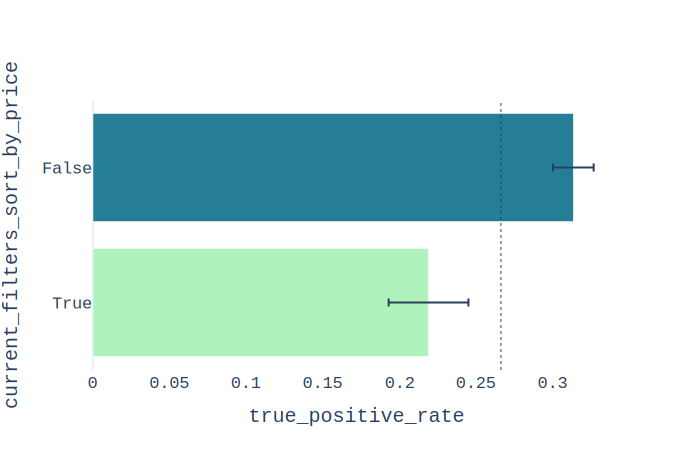

In [303]:
fig.show(renderer="svg")



fig.write_image("output/tmp/metrics/recsys_fairnes_{}.eps".format(input_features))    

In [304]:
df_metrics.head()

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C
sub,,,,,,
True,current_filters_sort_by_price.1.0,current_filters_sort_by_price,1018,1303,0.218856,0.026016
False,current_filters_sort_by_price.0.0,current_filters_sort_by_price,3013,11115,0.313278,0.013276


In [305]:
df_total.head()

,total_class,total_individuals
sub,,
True,1018 (25.25 %),1303 (10.49 %)
False,3013 (74.75 %),11115 (89.51 %)
total,4031,12418


### current_filters_sort_by_price

In [306]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_cccf64b73d_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'city_idx'
input_metrics     = 'true_positive_rate'

In [317]:
input_models_eval

'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_cccf64b73d_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'

In [319]:
# sub_map = {'0': "Boston, USA",
#             '1': "Como, Italy",
#             '2': "Chicago, USA",
#             '3': "Lausanne, Switzerland",
#             '4': "Dublin, Ireland",
#             '5': "Rio de Janeiro, Brazil",
#             '6': "Barcelona, Spain",
#             '7': "Copenhagen, Denmark",
#             '8': "Vienna, Austria",
#             '9': "New York, USA",
#             '10': "Hong Kong, Hong Kong",
#             '11': "Vancouver, Canada"}

sub_map = {'0': "Boston",
            '1': "Como",
            '2': "Chicago",
            '3': "Lausanne",
            '4': "Dublin",
            '5': "Rio de Janeiro",
            '6': "Barcelona",
            '7': "Copenhagen",
            '8': "Vienna",
            '9': "New York",
            '10': "Hong Kong",
            '11': "Vancouver"}


fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = sub_map)

/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz/util.py:21: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




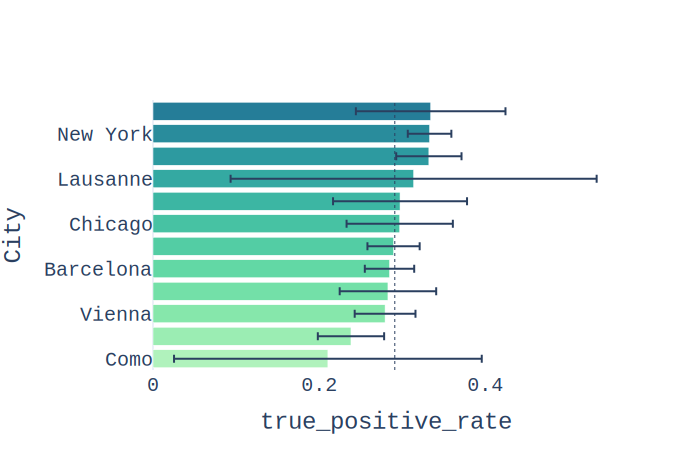

In [325]:

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="City")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 20}, height=600)



fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format(input_features))    

In [150]:
df_metrics.head(50)

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C
sub,,,,,,
"Como, Italy",city_idx.1,city_idx,30,30,0.210526,0.185211
"Dublin, Ireland",city_idx.4,city_idx,263,1035,0.238311,0.039911
"Vienna, Austria",city_idx.8,city_idx,392,1282,0.279375,0.036585
"Copenhagen, Denmark",city_idx.7,city_idx,125,572,0.282810,0.058084
"Barcelona, Spain",city_idx.6,city_idx,639,1652,0.284694,0.029722
"Rio de Janeiro, Brazil",city_idx.5,city_idx,567,2114,0.289564,0.031434
"Chicago, USA",city_idx.2,city_idx,152,375,0.296978,0.063965
"Boston, USA",city_idx.0,city_idx,109,198,0.297377,0.080639
"Lausanne, Switzerland",city_idx.3,city_idx,20,21,0.313725,0.220319


In [151]:
df_total.head()

,total_class,total_individuals
sub,,
"Como, Italy",30 (0.88 %),30 (0.24 %)
"Dublin, Ireland",263 (7.69 %),1035 (8.33 %)
"Vienna, Austria",392 (11.46 %),1282 (10.32 %)
"Copenhagen, Denmark",125 (3.65 %),572 (4.61 %)
"Barcelona, Spain",639 (18.68 %),1652 (13.30 %)


### acessible hotel/park

In [328]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_43d5853a51_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'accessible hotel'
input_metrics     = 'true_positive_rate'

/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz/util.py:21: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




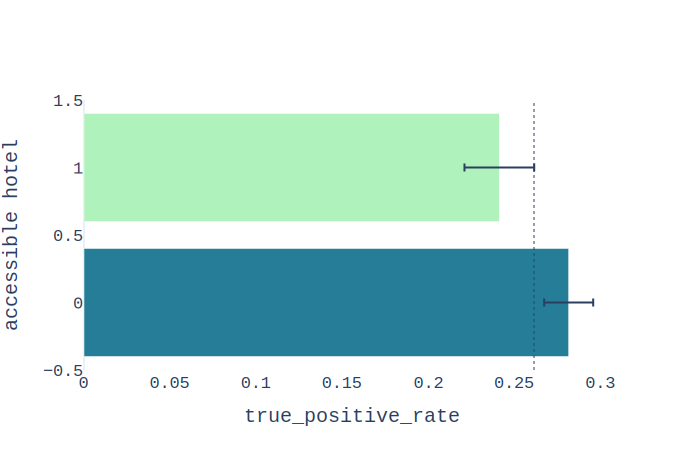

In [329]:
fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = None)
fig.show(renderer="svg")

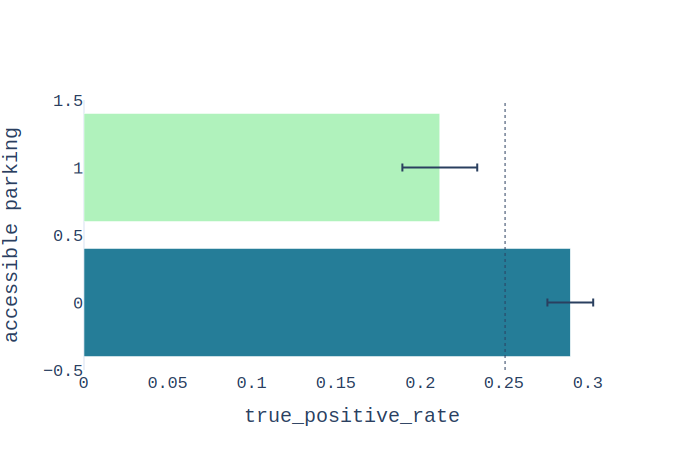

In [330]:
fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, 'accessible parking', input_metrics,
                                                 sub_map = None)
fig.show(renderer="svg")

In [331]:
input_features
sub_map = None

In [332]:
import plotly.express as px
print(px.colors.sequential.Tealgrn)

['rgb(176, 242, 188)', 'rgb(137, 232, 172)', 'rgb(103, 219, 165)', 'rgb(76, 200, 163)', 'rgb(56, 178, 163)', 'rgb(44, 152, 160)', 'rgb(37, 125, 152)']


In [333]:
metrics = []


def plot_fairness_mistreatment(df, metric, title=""):
    data = []

    data.append(go.Bar(y=df.index, x=df[metric], orientation='h',
                    error_x= dict(type='data', array=df[metric+"_C"]) if metric+"_C" in df.columns else {}  ,
                    marker={'color': [px.colors.sequential.Tealgrn[i] for i in df.color]})) #Plotly3

    fig = go.Figure(data=data)
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    xaxis_title=metric,
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        yref='paper', y0= 0, y1= 1,
        xref='x', x0= df[metric].mean(), x1= df[metric].mean()
      )
    ])

    st.plotly_chart(fig)

    return fig

for input_features in ['accessible parking', 'accessible hotel']:
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)

    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    metrics.append(df_metrics)

metrics = pd.concat(metrics)
metrics

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C
sub,,,,,,
1,accessible parking.1,accessible parking,1127,2546,0.211680,0.022268
0,accessible parking.0,accessible parking,3193,9872,0.289314,0.013621
1,accessible hotel.1,accessible hotel,1376,3716,0.241163,0.020246
0,accessible hotel.0,accessible hotel,3133,8702,0.281424,0.014234


In [334]:
metrics.reset_index()
metrics['sub'] = ['parking<br>True', 'parking<br>False', 'hotel<br>True', 'hotel<br>False']
metrics['color'] = [2,2, 5,5]
metrics = metrics.set_index('sub')
metrics

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C,color
sub,,,,,,,
parking<br>True,accessible parking.1,accessible parking,1127,2546,0.211680,0.022268,2
parking<br>False,accessible parking.0,accessible parking,3193,9872,0.289314,0.013621,2
hotel<br>True,accessible hotel.1,accessible hotel,1376,3716,0.241163,0.020246,5
hotel<br>False,accessible hotel.0,accessible hotel,3133,8702,0.281424,0.014234,5


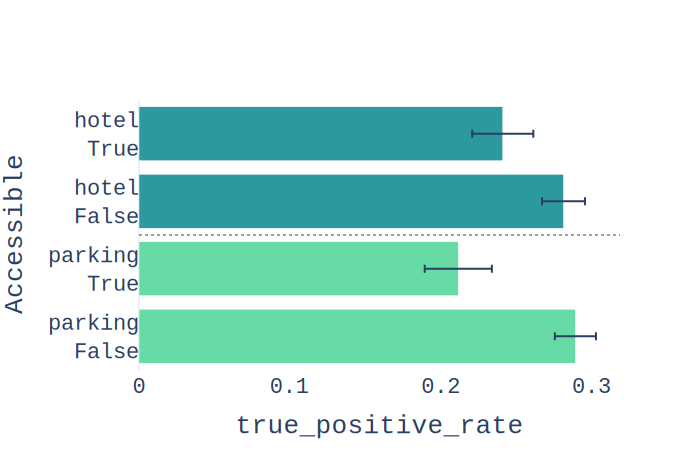

In [335]:
fig = plot_fairness_mistreatment(metrics, input_metrics, title="")

fig.update_layout(shapes=[
  dict(
    type= 'line',
    line=dict(
        width=1,
        dash="dot",
    ),        
    xref='paper', x0= 0, x1= 1,
    yref='y',     y0= 1.5, y1= 1.5
  )
])

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(yaxis={'categoryorder':'array', 'categoryarray':['parking<br>False', 'parking<br>True', 'hotel<br>False', 'hotel<br>True']})
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="Accessible")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 22}, height=550)

fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format("accessible"))    
fig.show(renderer="svg")

## Business hotel

In [336]:
metrics = []
for input_features in ['hotel', 'house / apartment']:
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)

    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    metrics.append(df_metrics)

metrics = pd.concat(metrics).reset_index().sort_values(['sub_key', 'sub'])
metrics

,sub,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C
0,0,hotel.0,hotel,1595,2126,0.209243,0.021453
1,1,hotel.1,hotel,2614,10292,0.291112,0.013488
3,0,house / apartment.0,house / apartment,3006,11541,0.306631,0.013065
2,1,house / apartment.1,house / apartment,854,877,0.139288,0.026247


In [337]:
#metrics.reset_index().sort_values('sub_key')
metrics['color'] = [5,5, 2,2]
metrics['sub']   = ['hotel<br>False', 'hotel<br>True', 'house/apart<br>False', 'house/apart<br>True']
metrics = metrics.set_index('sub')
metrics

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C,color
sub,,,,,,,
hotel<br>False,hotel.0,hotel,1595,2126,0.209243,0.021453,5
hotel<br>True,hotel.1,hotel,2614,10292,0.291112,0.013488,5
house/apart<br>False,house / apartment.0,house / apartment,3006,11541,0.306631,0.013065,2
house/apart<br>True,house / apartment.1,house / apartment,854,877,0.139288,0.026247,2


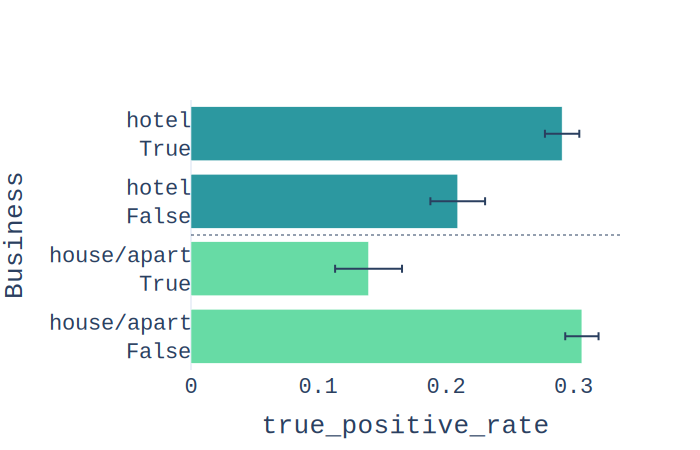

In [338]:
fig = plot_fairness_mistreatment(metrics, input_metrics, title="")

fig.update_layout(shapes=[
  dict(
    type= 'line',
    line=dict(
        width=1,
        dash="dot",
    ),        
    xref='paper', x0= 0, x1= 1,
    yref='y',     y0= 1.5, y1= 1.5
  )
])

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(yaxis={'categoryorder':'array', 'categoryarray':['house/apart<br>False', 'house/apart<br>True', 'hotel<br>False', 'hotel<br>True']})
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="Business")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 22}, height=550)



fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format("business"))    
fig.show(renderer="svg")

### Childcare

In [285]:
metrics = []
for input_features in ['childcare', 'family friendly']:
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)

    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    metrics.append(df_metrics)

metrics = pd.concat(metrics)
metrics

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C
sub,,,,,,
1,childcare.1,childcare,1027,2802,0.222654,0.022938
0,childcare.0,childcare,3222,9616,0.288659,0.013728
0,family friendly.0,family friendly,1942,2753,0.229201,0.019934
1,family friendly.1,family friendly,2446,9665,0.285930,0.014014


In [286]:
metrics.reset_index()
metrics['sub'] = ['childcare<br>True', 'childcare<br>False', 'family friendly<br>True', 'family friendly<br>False']
metrics['color'] = [2,2, 5,5]
metrics = metrics.set_index('sub')
metrics

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C,color
sub,,,,,,,
childcare<br>True,childcare.1,childcare,1027,2802,0.222654,0.022938,2
childcare<br>False,childcare.0,childcare,3222,9616,0.288659,0.013728,2
family friendly<br>True,family friendly.0,family friendly,1942,2753,0.229201,0.019934,5
family friendly<br>False,family friendly.1,family friendly,2446,9665,0.285930,0.014014,5


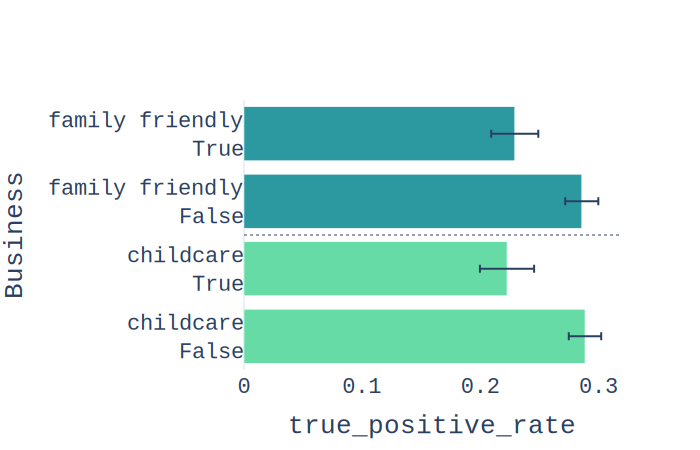

In [287]:
fig = plot_fairness_mistreatment(metrics, input_metrics, title="")



fig.update_layout(shapes=[
  dict(
    type= 'line',
    line=dict(
        width=1,
        dash="dot",
    ),        
    xref='paper', x0= 0, x1= 1,
    yref='y',     y0= 1.5, y1= 1.5
  )
])

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(yaxis={'categoryorder':'array', 'categoryarray':['childcare<br>False', 'childcare<br>True', 'family friendly<br>False', 'family friendly<br>True']})
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="Business")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 22}, height=550)




fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format("businesscare"))    
fig.show(renderer="svg")

### popularity_BIN

In [29]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_cccf64b73d_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'price_BIN'
input_metrics     = 'true_positive_rate'

In [30]:
sub_map = {"0.0": "1º Quartil", "1.0": "2º Quartil", "2.0": "3º Quartil", "3.0": "4º Quartil"}



fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = sub_map)

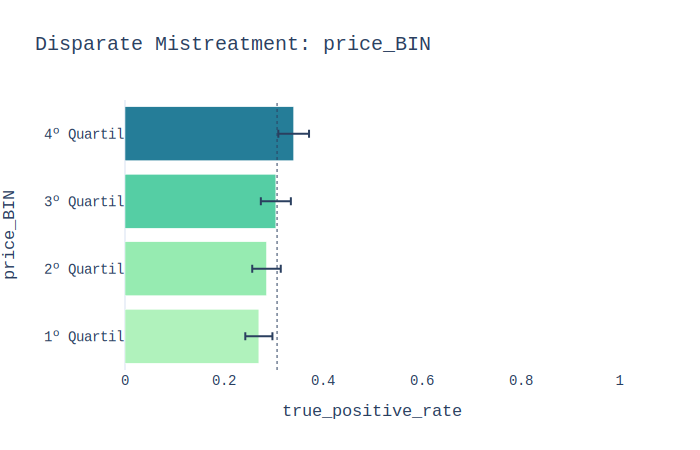

In [31]:
fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_{}.eps".format(input_features))    

In [32]:
df_metrics.head(50)

,feature,sub_key,total_class,total_individuals,true_positive_rate,true_positive_rate_C
sub,,,,,,
1º Quartil,price_BIN.0.0,price_BIN,991,2018,0.270440,0.027400
2º Quartil,price_BIN.1.0,price_BIN,973,1557,0.285857,0.028806
NaN,price_BIN.9.0,price_BIN,507,719,0.295310,0.041861
NaN,price_BIN.6.0,price_BIN,813,1185,0.304013,0.031949
3º Quartil,price_BIN.2.0,price_BIN,896,1271,0.304748,0.030330
NaN,price_BIN.8.0,price_BIN,573,901,0.306002,0.037087
NaN,price_BIN.5.0,price_BIN,837,1164,0.312398,0.032391
NaN,price_BIN.4.0,price_BIN,948,1243,0.324986,0.030851
NaN,price_BIN.7.0,price_BIN,695,997,0.327449,0.035268


In [33]:
df_total.head()

,total_class,total_individuals
sub,,
1º Quartil,991 (12.13 %),2018 (16.25 %)
2º Quartil,973 (11.91 %),1557 (12.54 %)
NaN,507 (6.20 %),719 (5.79 %)
NaN,813 (9.95 %),1185 (9.54 %)
3º Quartil,896 (10.96 %),1271 (10.24 %)


### All

In [18]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_43d5853a51_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'

df_all_metrics    = load_fairness_metrics().loc[input_models_eval]

for input_features in df_all_metrics['sub_key'].unique():
    sub_map = None
    print(input_features)
    fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics, sub_map = sub_map)    
    #fig.show(renderer="svg")
    fig.write_image("output/tmp/metrics/recsys_fairnes_mistreatment_{}.png".format(input_features.replace("/", "")))    

1 star


/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz/util.py:21: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




2 star
3 star
4 star
5 star
accessible hotel
accessible parking
adults only
air conditioning
airport hotel
airport shuttle
all inclusive (upon inquiry)
balcony
bathtub
beach
beach bar
beauty salon
bed & breakfast
bike rental
boat rental
body treatments
boutique hotel
bowling
bungalows
business centre
business hotel
cable tv
camping site
car park
casa rural (es)
casino (hotel)
central heating
childcare
club hotel
computer with internet
concierge
conference rooms
convenience store
convention hotel
cosmetic mirror
cot
country hotel
deck chairs
design hotel
desk
direct beach access
diving
doctor on-site
eco-friendly hotel
electric kettle
excellent rating
express check-in / check-out
family friendly
fan
farmstay
fitness
flatscreen tv
free wifi (combined)
free wifi (public areas)
free wifi (rooms)
fridge
from 2 stars
from 3 stars
from 4 stars
gay-friendly
golf course
good rating
guest house
gym
hairdresser
hairdryer
halal food
hammam
health retreat
hiking trail
honeymoon
horse riding
hostal 

## Disparate treatment

In [356]:
def plot_fairness_treatment(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'



    
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index#[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    df    = df.groupby(["action", metric]).agg(
              rewards=("rewards", 'count'),
              metric=(score, 'mean'),
              confidence=(score, confidence)).reset_index()#.sort_values("rhat_scores")

    df    = df[df.rewards > min_count] # filter min interactions
    #df    = df[df.action.isin(items)]

    #------------------
    df_group = df[df['rewards'] > min_count].groupby('action').agg({metric: 'count'}).reset_index()
    df_all   = df_group[df_group[metric] >= 3]['action'].values    

    df       = df[df.action.isin(df_all)].iloc[0:int(3*5)]
    
    
    df3 = df.groupby('action').agg(metric_max=('metric', 'max'), metric_min=('metric', 'min')).reset_index()
    df3['diff'] = df3['metric_max'] - df3['metric_min']

    df = df.merge(df3, on='action').sort_values('diff', ascending=False)
    
    #df_all


    #df    = df[:int(5 * 3)]
    
    for group, rows in df.groupby(metric):
        data.append(go.Bar(name=legend[str(group)], 
                            x=["ID:"+str(a) for a in rows["action"]], 
                            y=rows['metric'],
                            error_y= dict(type='data', array=rows['confidence']) )) #px.colors.sequential.Purp [i for i in range(len(rows))]

        i += 1
    fig = go.Figure(data=data)

    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score,
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        xref='paper', x0= 0, x1= 1,
        yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
      )
    ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig

In [357]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
df_instances      = load_fairness_df().loc[input_models_eval]

input_features    = 'device_idx'
input_metrics     = 'true_positive_rate'
input_items_top = True
input_items     = []

/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz/util.py:21: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



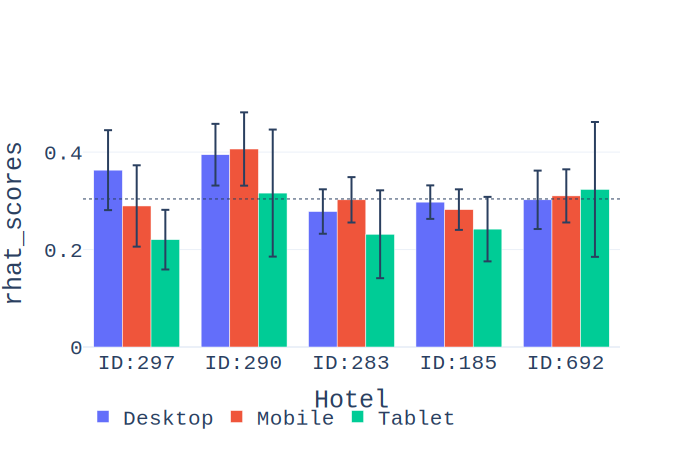

In [359]:
fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
                          title="",
                          legend={"0.0": "Desktop", "1.0": "Mobile", "2.0": "Tablet"})
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 21}, height=600)



# Set custom x-axis labels
fig.update_yaxes(nticks=5)
fig.update_layout(xaxis_title="Hotel")


fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/paper/recsys_fairnes_impact_{}.eps".format(input_features))    

### Image 2

In [212]:
input_features    = 'popularity_BIN'

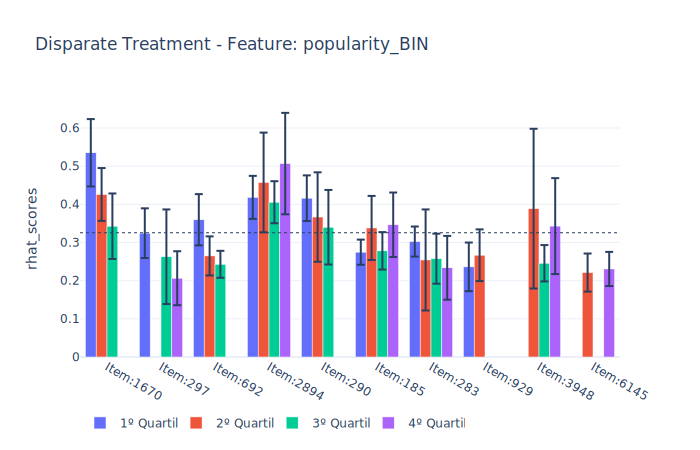

In [71]:
fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0.0": "1º Quartil", "1.0": "2º Quartil", "2.0": "3º Quartil", "3.0": "4º Quartil"})


fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

### All

In [72]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
df_instances      = load_fairness_df().loc[input_models_eval]
input_metrics     = 'true_positive_rate'
input_items_top = True
input_items     = []

In [82]:
# def plot_fairness_treatment(df, metric, items, min_count=10, top=False, title="", legend=None):
#     data  = []
#     i     = 0
#     score = 'rhat_scores'

    
#     if top:
#         # Diff min max score
#         df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
#         items  = df_diff.sort_values('total', ascending=False).index[:10]

#     df    = df.groupby(["action", metric]).agg(
#               rewards=("rewards", 'count'),
#               metric=(score, 'mean'),
#               confidence=(score, confidence)).reset_index()#.sort_values("rhat_scores")

#     df    = df[df.rewards > min_count] # filter min interactions

#     #------------------
#     df_group = df[df['rewards'] > min_count].groupby('action').agg({metric: 'count'}).reset_index()

#     df       = df[df.action.isin(items)]#.iloc[0:int(3*10)]
    
    
#     df3 = df.groupby('action').agg(metric_max=('metric', 'max'), metric_min=('metric', 'min')).reset_index()
#     df3['diff'] = df3['metric_max'] - df3['metric_min']

#     df = df.merge(df3, on='action').sort_values('diff', ascending=False)
    
#     for group, rows in df.groupby(metric):
#         data.append(go.Bar(name=str(group), 
#                             x=["Item"+":"+str(a) for a in rows["action"]], 
#                             y=rows['metric'],
#                             error_y= dict(type='data', array=rows['confidence']) )) #px.colors.sequential.Purp [i for i in range(len(rows))]

#         i += 1
#     fig = go.Figure(data=data)

#     # Change the bar mode
#     fig.update_layout(template=TEMPLATE, legend_orientation="h", 
#                     yaxis_title=score,
#                     legend=dict(y=-0.2), title=title)
#     #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
#     #fig.update_layout(coloraxis = {'colorscale':'Purp'})

#     fig.update_layout(shapes=[
#       dict(
#         type= 'line',
#         line=dict(
#             width=1,
#             dash="dot",
#         ),        
#         xref='paper', x0= 0, x1= 1,
#         yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
#       )
#     ])

#     st.plotly_chart(fig)
#     st.dataframe(df)

#     return fig

# df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
# input_features    = 'current_filters_1_star'
# fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
#                           title="Disparate Impact - Feature: "+input_features)

# fig.show(renderer="svg")
# #if fig != None:
# #    fig.write_image("output/tmp/metrics/recsys_fairnes_impact_{}.png".format(input_features.replace("/", ""))) 

In [80]:
input_items_top

True

In [83]:
# df_all_metrics    = load_fairness_metrics().loc[input_models_eval]

# for input_features in df_all_metrics['sub_key'].unique():
#     sub_map = None
#     print(input_features)
    
    
#     fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
#                               title="Disparate Impact - Feature: "+input_features)

#     #fig.show(renderer="svg")
#     if fig != None:
#         fig.write_image("output/tmp/metrics/recsys_fairnes_impact_{}.png".format(input_features.replace("/", "")))    

## Disparate Mistritment

In [41]:
df_instances.head()

,action,action_type_idx,action_type_item_idx,city_idx,clicked,current_filters_1_star,current_filters_2_star,current_filters_3_star,current_filters_4_star,current_filters_5_star,...,popularity,popularity_BIN,popularity_item_idx,pos_item_idx,price,price_BIN,rewards,rhat_scores,sum_action_item_before,view
path,,,,,,,,,,,,,,,,,,,,,
TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,1868,NaN,NaN,8,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,2.0,NaN,5,NaN,0.0,0,0.971384,NaN,NaN
TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,1868,NaN,NaN,8,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,1.0,NaN,0,NaN,0.0,0,0.994982,NaN,NaN
TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,1868,NaN,NaN,8,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,2.0,NaN,6,NaN,0.0,0,0.268792,NaN,NaN
TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,1868,NaN,NaN,8,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,2.0,NaN,17,NaN,0.0,0,0.146350,NaN,NaN
TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps,1868,NaN,NaN,8,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,3.0,NaN,5,NaN,0.0,0,0.587561,NaN,NaN


In [82]:
df_group = df_instances.groupby('action').agg(total=('rewards', 'count'))#/len(df_instances)
df_group#.plot(kind='bar')

,total
action,
5,1
6,2
7,5
8,1
11,3
...,...
12285,1
12299,12
12314,1


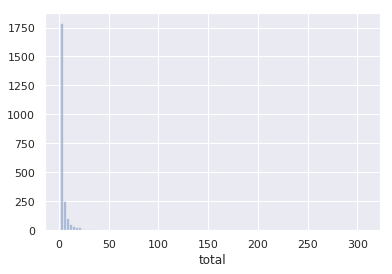

In [87]:
from scipy.stats import norm
ax = sns.distplot(df_group.total, kde=False, bins=100)

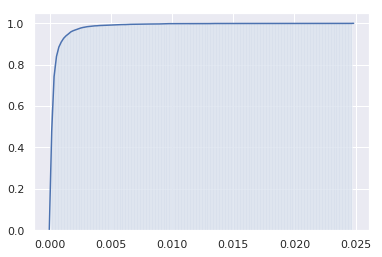

In [79]:
kwargs = {'cumulative': True}
sns.distplot(sorted(df_group.total), hist_kws=kwargs, kde_kws=kwargs, bins=500)
#plt.xlim(0, 0.01)

In [64]:
df_group.total

action
5        0.000081
6        0.000161
7        0.000403
8        0.000081
11       0.000242
           ...   
12285    0.000081
12299    0.000966
12314    0.000081
12321    0.000081
12328    0.000242
Name: total, Length: 2379, dtype: float64

## Disparate Impact

In [169]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_cccf64b73d_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'

df_instances      = load_fairness_df().loc[input_models_eval]

input_features    = 'device_idx'
input_metrics     = 'true_positive_rate'
input_items_top = True
input_items     = []

/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz/util.py:21: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




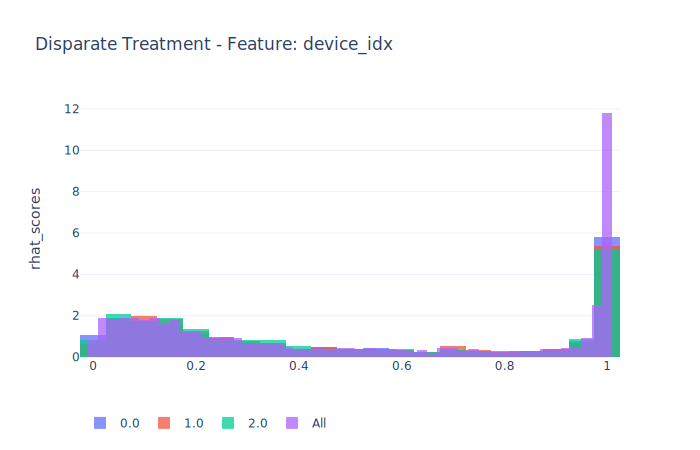

In [170]:
def plot_fairness_treatment2(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'

   
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    if len(items) > 0:
        df       = df[df.action.isin(items)]#.iloc[0:10]
    #print(df)


    #df    = df[:int(5 * 3)]


    for group, rows in df.groupby(metric):
        data.append(go.Histogram(name=group,
                                x=rows[score], 
                                histnorm='probability density')) #px.colors.sequential.Purp [i for i in range(len(rows))]

        i += 1
        
    
    data.append(go.Histogram(name="All",
                            x=df[score], 
                            histnorm='probability density')) #px.colors.sequential.Purp [i for i in range(len(rows))]
    
            
    fig = go.Figure(data=data)

    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score, 
                    legend=dict(y=-0.2), title=title)
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)


    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

#     fig.update_layout(shapes=[
#       dict(
#         type= 'line',
#         line=dict(
#             width=1,
#             dash="dot",
#         ),        
#         xref='paper', x0= 0, x1= 1,
#         yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
#       )
#     ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig


fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0": "Desktop", "1": "Mobile", "2": "Tablet"})

#fig.update_layout(barmode='stack')

fig.show(renderer="svg")
#fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

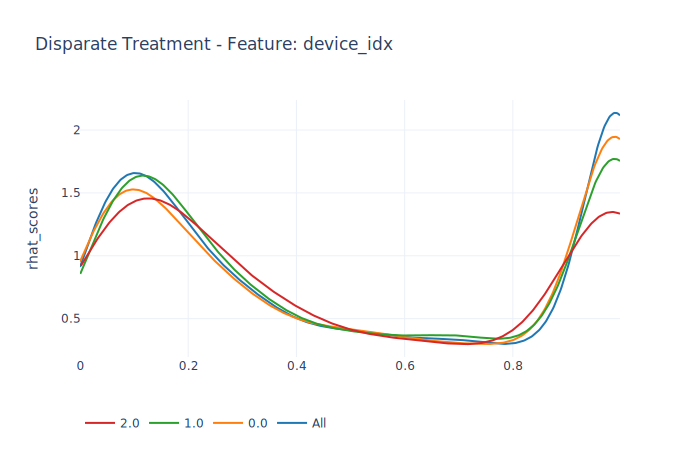

In [171]:
import plotly.figure_factory as ff

def plot_fairness_treatment2(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'

   
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    if len(items) > 0:
        df       = df[df.action.isin(items)]#.iloc[0:10]
    #print(df)


    #df    = df[:int(5 * 3)]
    group_labels = []
    
    data.append(df[score])
    group_labels.append("All")   
    
    for group, rows in df.groupby(metric):
        group_labels.append(str(group))
        data.append(rows[score]) 

        i += 1
  
            
    fig = ff.create_distplot(data, group_labels, show_rug=False, show_hist=False)
        
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score, 
                    legend=dict(y=-0.2), title=title)
    #fig.update_layout(barmode='overlay')
    #fig.update_traces(opacity=0.75)


    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

#     fig.update_layout(shapes=[
#       dict(
#         type= 'line',
#         line=dict(
#             width=1,
#             dash="dot",
#         ),        
#         xref='paper', x0= 0, x1= 1,
#         yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
#       )
#     ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig


fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0": "Desktop", "1": "Mobile", "2": "Tablet"})

#fig.update_layout(barmode='stack')

fig.show(renderer="svg")
#fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

In [ ]:
df_all_metrics    = load_fairness_metrics().loc[input_models_eval]

for input_features in df_all_metrics['sub_key'].unique():
    print(input_features)
    
    try:
        fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                                      title="Disparate Treatment - Feature: "+input_features)

    #fig.show(renderer="svg")

        fig.write_image("output/tmp/metrics/recsys_fairnes_Treatment_2{}.png".format(input_features.replace("/", "")))    
    except:
        print("Error", input_features)
        pass